In [58]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
import xarray as xr
from sklearn.preprocessing import scale
import scipy
from scipy.special import expit
import pytensor.tensor as pt

If you cannot solve the proposed problem try to solve first some related problem. Could you imagine a more accessible related problem? A more general problem? A special problem? An analogous problem?

Move laterally when stuck

Try a simpler model first, then return to the more complex problem


## Can't always get what you want

Ask what you can get, sensitivity analysis, mediators.

## Trolley Problems

Data:

- Different trolley problems/moral questions with principles in opposition

- Ask for response regarding moral intuition

- Attempt to empirically study the ethics of moral problems.

- 3 latent features: Action, Intention, Contact

- 331 individuals (age,gender,edu)

- Voluntary participation (online)

- 30 different trolley problems

- action/intention/contact varied 

- 9930 responses: How appropriate (1-7)?

In [2]:
trolley = pd.read_csv('Data/Trolley.csv',sep=';')

trolley.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


array([[<AxesSubplot: title={'center': 'response'}>]], dtype=object)

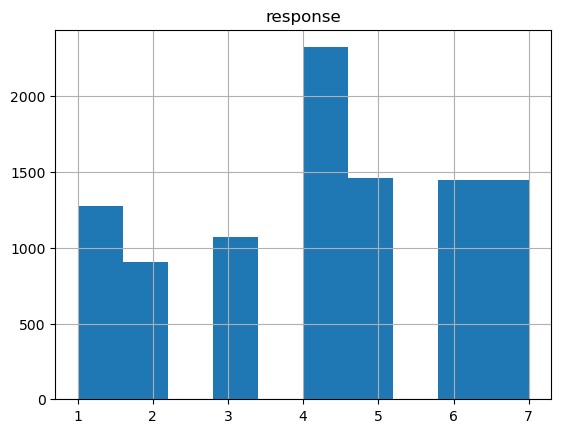

In [3]:
trolley.hist(column='response')
#Not metric, bounded, odd distribution

Estimand: How do action, intention, contact influence response to a trolley story? 

How are influences of A/I/C associated with other variables?

## Ordered Categories

Categories: Discrete types

Ordered categories: Discrete types with ordered relationships

bad, good, excellent (7 is more than 1, just don't know by how much)

Probably much easier to go from 4 to 5 than from 6 to 7

Anchor points common (like 4 in our data)

Not everyone shares the same anchor points 

## Ordered = Cumulative

Adds the previous result to the next result. 

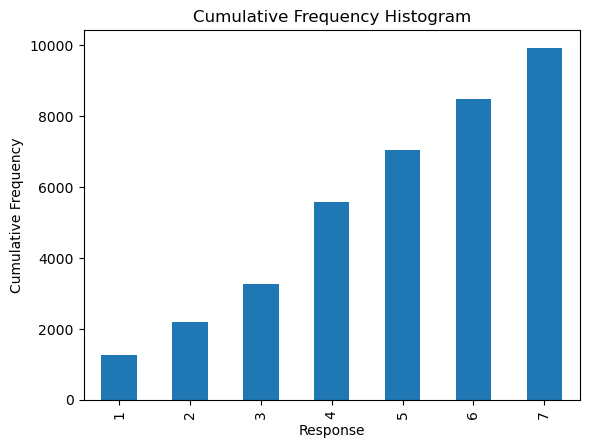

In [4]:
cumulative_sum = trolley['response'].value_counts().sort_index().cumsum()

cumulative_sum.plot(kind='bar')
plt.title('Cumulative Frequency Histogram')
plt.xlabel('Response')
plt.ylabel('Cumulative Frequency')
plt.show()

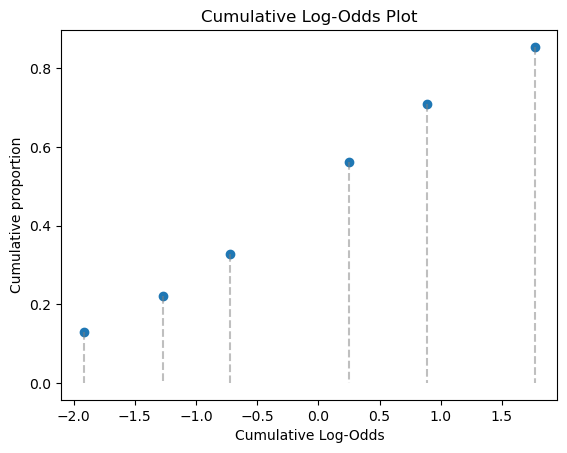

In [5]:
# Calculate the cumulative probability of each response
cumulative_prob = cumulative_sum/cumulative_sum.iloc[-1]
# Calculate the cumulative log-odds
cumulative_log_odds = np.log(cumulative_prob / (1 - cumulative_prob))
# Plot the cumulative log-odds
#cumulative_log_odds.plot(kind='bar')
plt.scatter(x=cumulative_log_odds,y=cumulative_prob)

for x, y in zip(cumulative_log_odds, cumulative_prob):
    plt.plot([x, x], [y, 0], '--', color='gray', alpha=0.5)

plt.title('Cumulative Log-Odds Plot')
plt.xlabel('Cumulative Log-Odds')
plt.ylabel('Cumulative proportion')
plt.show()


Going to use log-odds (logit links). Need to translate probability to log-odds. 

Gives cumulative log-odds. Each point is the cutpoint

The number of cutpoints you need is 1 less that the number of outcomes, last one is free and is whatever is left over. The outcomes live inthe gaps between the cuts, last one lives off to the right into infinity because everything after that cutpoint must be 7 (in our example).  

Pr(R = k) = Pr(R<= 3) - Pr(R<=2)

Gives discrete categories, force order. 

log(Pr(R <= k) / (1-Pr(R<=k)) = a

left is cumulative log odds
a is the cutpoint to estimate 


## Where's the GLM?

So far just estimating the histogram

How to make it a function of variables?

1) Stratify cutpoints

2) Offset each cutpoint by value of linear model  phi. 

Ri ~ OrderedLogit(phi,alpha)

bigger phis give you smaller average responses, opposite for smaller phis. usually subtract phi . 

In [6]:
trolley['action'].shape

(9930,)

In [7]:
trolley['response'].values -1

array([3, 2, 3, ..., 6, 1, 1], dtype=int64)

In [9]:
# Starting off easy
with pm.Model() as easy_trolley:
    A     = pm.MutableData('A',trolley['action'].values)
    I     = pm.MutableData('I',trolley['intention'].values)
    C     = pm.MutableData('C',trolley['contact'].values)
    R     = pm.MutableData('R',trolley['response'].values -1) # 0-6 instead of 1-7
    
    #Cutpoints instead of alpha
    #cutpoints = pm.Normal('cutpoints',0,1)#,transform = pm.distributions.transforms.ordered)#,shape=6)
    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.0,
        transform=pm.distributions.transforms.univariate_ordered, #At time of writing this isn't documented
        shape=6,
        testval=np.arange(6) - 2.5,
    )
    bA    = pm.Normal('bA',0,0.5)
    bI    = pm.Normal('bI',0,0.5)
    bC    = pm.Normal('bC',0,0.5)
    
    phi   = pm.Deterministic('phi',bA*A + bI*I + bC*C)
    
    Response     = pm.OrderedLogistic('Response', cutpoints=cutpoints,eta = phi,observed=R,shape=R.shape)
    easy_trace = pm.sample()
    

C:\Users\Kieran McGee\AppData\Local\Temp\ipykernel_27492\225190178.py:10: FutureWarning: The `testval` argument is deprecated; use `initval`.
  cutpoints = pm.Normal(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints, bA, bI, bC]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 137 seconds.


In [11]:
az.summary(easy_trace,var_names=['bA','bI','bC','cutpoints']) # Note you have to give the list of vars otherwise it fails

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bA,-0.695,0.041,-0.770,-0.614,0.001,0.001,2631.0,2789.0,1.0
bI,-0.712,0.036,-0.778,-0.643,0.001,0.000,3207.0,3166.0,1.0
bC,-0.945,0.050,-1.045,-0.857,0.001,0.001,2771.0,2819.0,1.0
cutpoints[0],-2.825,0.047,-2.913,-2.735,0.001,0.001,1856.0,2223.0,1.0
cutpoints[1],-2.141,0.043,-2.221,-2.061,0.001,0.001,2184.0,2522.0,1.0
cutpoints[2],-1.557,0.040,-1.629,-1.479,0.001,0.001,2316.0,2810.0,1.0
cutpoints[3],-0.537,0.036,-0.607,-0.471,0.001,0.001,2574.0,3143.0,1.0
cutpoints[4],0.132,0.037,0.066,0.204,0.001,0.000,2795.0,3212.0,1.0
cutpoints[5],1.040,0.040,0.967,1.116,0.001,0.000,3209.0,3042.0,1.0


In [17]:
with easy_trolley:
    pm.set_data({'A':[0]*9930,
                'I':[0]*9930,
                'C':[0]*9930})
    
    r_000 = pm.sample_posterior_predictive(easy_trace)

Sampling: [Response]


In [18]:
r_000

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

Text(0.5, 1.0, 'A=0,I=0,C=0')

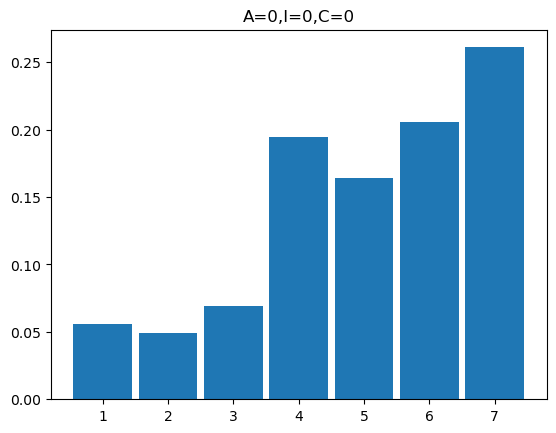

In [26]:
az.plot_dist(r_000.posterior_predictive.Response + 1)
plt.title('A=0,I=0,C=0')

In [23]:
with easy_trolley:
    pm.set_data({'A':[1]*9930,
                'I':[1]*9930,
                'C':[1]*9930})
    
    r_111 = pm.sample_posterior_predictive(easy_trace)

Sampling: [Response]


Text(0.5, 1.0, 'A=1,I=1,C=1')

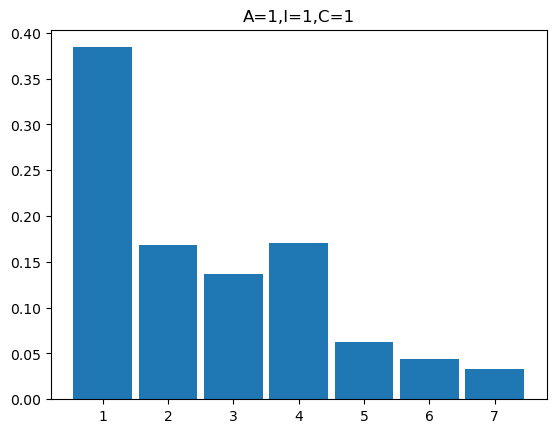

In [25]:
az.plot_dist(r_111.posterior_predictive.Response + 1)
plt.title('A=1,I=1,C=1')

Voluntary sample, participation P is influenced by E, Y and G. 

Thus E,Y,G covary in sample. P is a collider

## Endogenous Selection

Sample is selectd on a collider

Induces misleading associations among variables

Not possible here to estimate total effect of G, BUT can get direct effect

Need to stratify by E and Y and G 


In [27]:
trolley

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9925,ilpon,3,23,98;299,66,1,Graduate Degree,0,1,0,pon,0
9926,ilsha,6,15,98;299,66,1,Graduate Degree,0,1,0,sha,0
9927,ilshi,7,7,98;299,66,1,Graduate Degree,0,1,0,shi,0
9928,ilswi,2,18,98;299,66,1,Graduate Degree,0,1,0,swi,0


In [31]:
with pm.Model() as gender_trolley:
    G     = pm.MutableData('G',trolley['male'].values)
    A     = pm.MutableData('A',trolley['action'].values)
    I     = pm.MutableData('I',trolley['intention'].values)
    C     = pm.MutableData('C',trolley['contact'].values)
    R     = pm.MutableData('R',trolley['response'].values -1) # 0-6 instead of 1-7
    
    #Cutpoints instead of alpha
    #cutpoints = pm.Normal('cutpoints',0,1)#,transform = pm.distributions.transforms.ordered)#,shape=6)
    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.0,
        transform=pm.distributions.transforms.univariate_ordered, #At time of writing this isn't documented
        shape=6,
        testval=np.arange(6) - 2.5,
    )
    bA    = pm.Normal('bA',0,0.5,shape=2)
    bI    = pm.Normal('bI',0,0.5,shape=2)
    bC    = pm.Normal('bC',0,0.5,shape=2)
    
    phi   = pm.Deterministic('phi',bA[G]*A + bI[G]*I + bC[G]*C)
    
    Response     = pm.OrderedLogistic('Response', cutpoints=cutpoints,eta = phi,observed=R,shape=A.shape)
    gender_trace = pm.sample()
    

C:\Users\Kieran McGee\AppData\Local\Temp\ipykernel_27492\1118519015.py:10: FutureWarning: The `testval` argument is deprecated; use `initval`.
  cutpoints = pm.Normal(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints, bA, bI, bC]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 148 seconds.


In [32]:
az.summary(gender_trace,var_names=['bA','bI','bC','cutpoints'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bA[0],-0.883,0.052,-0.976,-0.784,0.001,0.001,3093.0,3423.0,1.0
bA[1],-0.531,0.049,-0.626,-0.444,0.001,0.001,2823.0,2941.0,1.0
bI[0],-0.896,0.049,-0.991,-0.807,0.001,0.001,3216.0,3307.0,1.0
bI[1],-0.555,0.045,-0.639,-0.471,0.001,0.001,3447.0,3109.0,1.0
bC[0],-1.064,0.068,-1.190,-0.940,0.001,0.001,3164.0,3014.0,1.0
bC[1],-0.838,0.063,-0.958,-0.719,0.001,0.001,3674.0,3307.0,1.0
cutpoints[0],-2.837,0.047,-2.924,-2.748,0.001,0.001,1855.0,2496.0,1.0
cutpoints[1],-2.154,0.043,-2.230,-2.068,0.001,0.001,1932.0,2502.0,1.0
cutpoints[2],-1.566,0.040,-1.642,-1.488,0.001,0.001,2065.0,2579.0,1.0
cutpoints[3],-0.534,0.037,-0.604,-0.466,0.001,0.001,2258.0,2735.0,1.0


In [34]:
with gender_trolley:
    pm.set_data({'A':[0]*9930,
                 'I':[1]*9930,
                 'C':[1]*9930,
                 'G':[1]*9930})
    
    r_011_g1 = pm.sample_posterior_predictive(gender_trace)

Sampling: [Response]


In [36]:
with gender_trolley:
    pm.set_data({'A':[0]*9930,
                 'I':[1]*9930,
                 'C':[1]*9930,
                 'G':[0]*9930})
    
    r_011_g0 = pm.sample_posterior_predictive(gender_trace)

Sampling: [Response]


Text(0.5, 1.0, 'A=0,I=1,C=1,G=1')

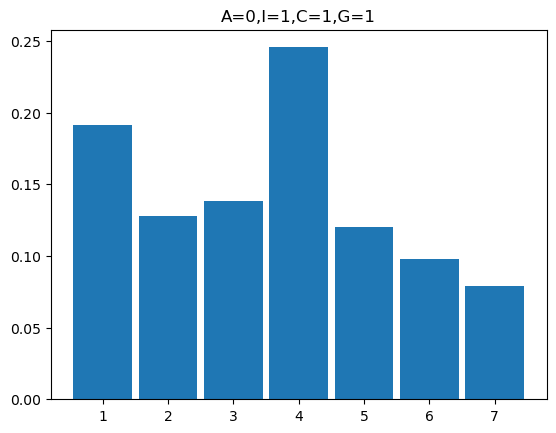

In [35]:
az.plot_dist(r_011_g1.posterior_predictive.Response + 1)
plt.title('A=0,I=1,C=1,G=1')

Text(0.5, 1.0, 'A=0,I=1,C=1,G=0')

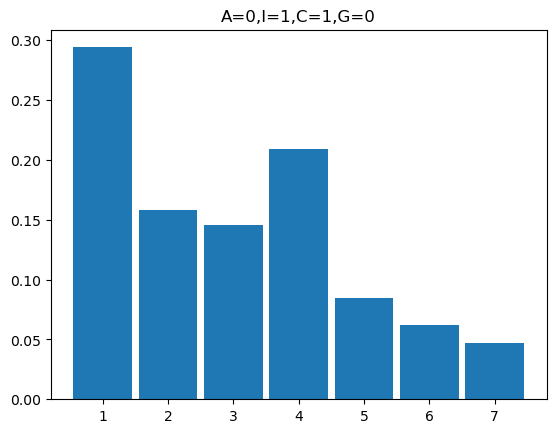

In [37]:
az.plot_dist(r_011_g0.posterior_predictive.Response + 1)
plt.title('A=0,I=1,C=1,G=0')

<AxesSubplot: >

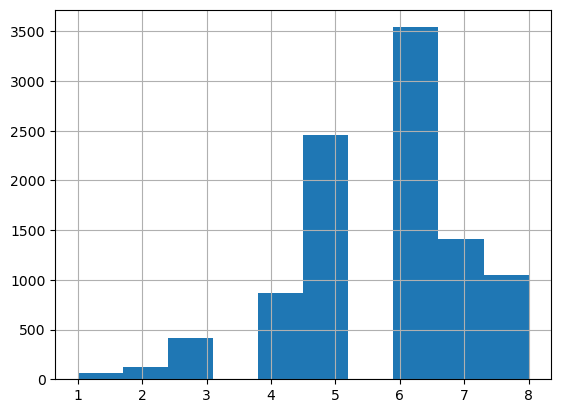

In [46]:

codes = [1,2,3,4,5,6,7,8]
levels = ['Elementary School','Middle School','Some High School','High School Graduate','Some College',"Bachelor's Degree",
         "Master's Degree",'Graduate Degree']
code_to_level = dict(zip(levels,codes))

trolley['edu_idx'] = trolley['edu'].map(code_to_level)
trolley['edu_idx'].hist()

Index(['Middle School', 'Bachelor's Degree', 'Some College', 'Master's Degree',
       'High School Graduate', 'Graduate Degree', 'Some High School',
       'Elementary School'],
      dtype='object')

<AxesSubplot: >

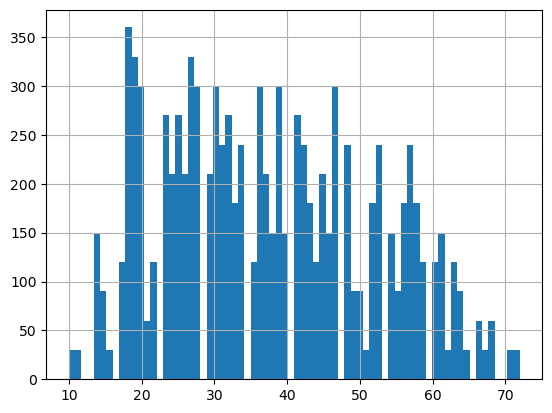

In [49]:
trolley['age'].hist(bins=72)

## Ordered monotonic predictors

Education is an ordered category

Unlikely that each level has same effect

Want a parameter for each level

But how to enforce ordering, so that each level has larger? (or smaller) effect that previous?

Each increment will get a new increment

1 = phi = 0

2 = phi = del1

3 = phi = del1 + del2 

phi = B * education level*proportion of maximum effect)


How do we set priors for the delta parameters?

delta parameters form a simplex

Simplex: vector that sums to 1

del ~ Dirichlet(a)
a = [some vector]

The bigger the elements of the a are, the smaller the difference between them .



In [50]:
[2]*7

[2, 2, 2, 2, 2, 2, 2]

In [59]:
with pm.Model() as edu_trolley:
    
    A     = pm.MutableData('A',trolley['action'].values)
    I     = pm.MutableData('I',trolley['intention'].values)
    C     = pm.MutableData('C',trolley['contact'].values)
    R     = pm.MutableData('R',trolley['response'].values -1) # 0-6 instead of 1-7
    E     = pm.MutableData('E',trolley['edu_idx'].values-1) #0-7 
    
    #Cutpoints instead of alpha
    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.0,
        transform=pm.distributions.transforms.univariate_ordered, #At time of writing this isn't documented
        shape=6,
        testval=np.arange(6) - 2.5,
    )
    delta = pm.Dirichlet('delta',np.repeat(2.0,7),shape=7)
    
    bA    = pm.Normal('bA',0,1)
    bI    = pm.Normal('bI',0,1)
    bC    = pm.Normal('bC',0,1)
    bE    = pm.Normal('bE',0,1)
    
    #eta instead of phi
    delta_j = pt.concatenate([pt.zeros(1),delta]) #0 at the beginning, so first education level gets 0 
    delta_j_cum = pt.cumsum(delta_j)
    eta   = bE*delta_j_cum[E] + bA*A + bI*I + bC*C
    
    Response = pm.OrderedLogistic('Response',cutpoints=cutpoints,eta=eta,observed=R,shape=A.shape)
    
    edu_trace = pm.sample()

C:\Users\Kieran McGee\AppData\Local\Temp\ipykernel_27492\478576775.py:10: FutureWarning: The `testval` argument is deprecated; use `initval`.
  cutpoints = pm.Normal(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cutpoints, delta, bA, bI, bC, bE]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 428 seconds.


In [60]:
az.summary(edu_trace,var_names=['cutpoints','bE','bC','bI','bA','delta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cutpoints[0],-3.008,0.127,-3.260,-2.777,0.003,0.002,1731.0,2100.0,1.0
cutpoints[1],-2.323,0.125,-2.567,-2.087,0.003,0.002,1678.0,2030.0,1.0
cutpoints[2],-1.739,0.124,-1.977,-1.495,0.003,0.002,1664.0,1918.0,1.0
cutpoints[3],-0.718,0.123,-0.971,-0.493,0.003,0.002,1713.0,1835.0,1.0
cutpoints[4],-0.048,0.123,-0.278,0.196,0.003,0.002,1713.0,1954.0,1.0
cutpoints[5],0.860,0.124,0.623,1.093,0.003,0.002,1729.0,1935.0,1.0
bE,-0.232,0.149,-0.526,0.055,0.004,0.003,1728.0,1666.0,1.0
bC,-0.954,0.050,-1.049,-0.862,0.001,0.001,4030.0,3107.0,1.0
bI,-0.716,0.037,-0.781,-0.644,0.000,0.000,6275.0,2932.0,1.0
bA,-0.701,0.041,-0.775,-0.623,0.001,0.000,4110.0,3221.0,1.0


In [62]:
with pm.Model() as edugenage_trolley:
    G     = pm.MutableData('G',trolley['male'].values)
    A     = pm.MutableData('A',trolley['action'].values)
    I     = pm.MutableData('I',trolley['intention'].values)
    C     = pm.MutableData('C',trolley['contact'].values)
    R     = pm.MutableData('R',trolley['response'].values -1) # 0-6 instead of 1-7
    E     = pm.MutableData('E',trolley['edu_idx'].values-1) #0-7 
    Y     = pm.MutableData('Y',scale(trolley['age'].values))
    #Cutpoints instead of alpha
    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.0,
        transform=pm.distributions.transforms.univariate_ordered, #At time of writing this isn't documented
        shape=6,
        testval=np.arange(6) - 2.5,
    )
    delta = pm.Dirichlet('delta',np.repeat(2.0,7),shape=7)
    
    bA    = pm.Normal('bA',0,1,shape=2)
    bI    = pm.Normal('bI',0,1,shape=2)
    bC    = pm.Normal('bC',0,1,shape=2)
    bE    = pm.Normal('bE',0,1,shape=2)
    bY    = pm.Normal('bY',0,1,shape=2)
    
    #eta instead of phi
    delta_j = pt.concatenate([pt.zeros(1),delta]) #0 at the beginning, so first education level gets 0 
    delta_j_cum = pt.cumsum(delta_j)
    eta   = bE[G]*delta_j_cum[E] + bA[G]*A + bI[G]*I + bC[G]*C + bY[G]*Y
    
    Response = pm.OrderedLogistic('Response',cutpoints=cutpoints,eta=eta,observed=R,shape=A.shape)
    
    edugenage_trace = pm.sample(chains=4,cores=8)

C:\Users\Kieran McGee\AppData\Local\Temp\ipykernel_27492\412414231.py:10: FutureWarning: The `testval` argument is deprecated; use `initval`.
  cutpoints = pm.Normal(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [cutpoints, delta, bA, bI, bC, bE, bY]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 433 seconds.


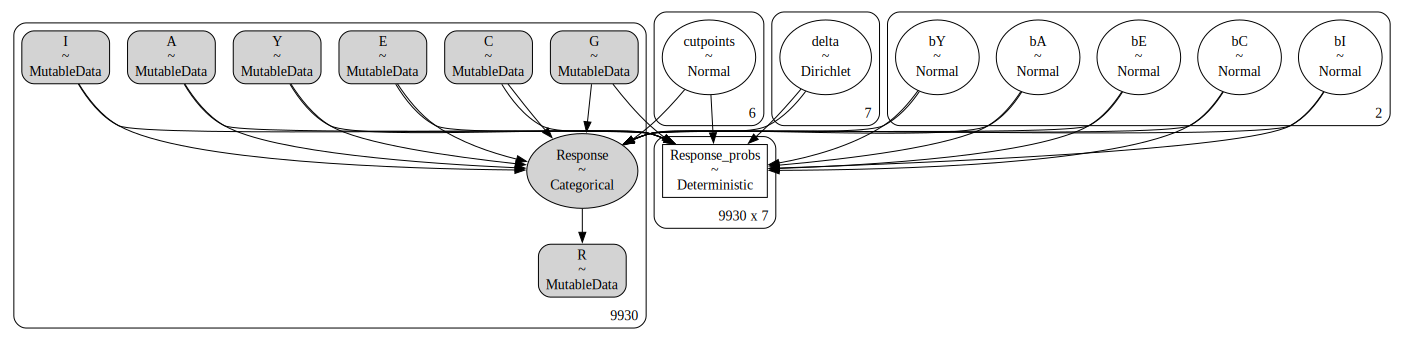

In [65]:
pm.model_to_graphviz(edugenage_trolley)

In [64]:
az.summary(edugenage_trace,var_names=['cutpoints','bE','bC','bI','bA','bY','delta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cutpoints[0],-2.920,0.107,-3.128,-2.730,0.003,0.002,1732.0,2217.0,1.0
cutpoints[1],-2.234,0.105,-2.431,-2.038,0.003,0.002,1744.0,2130.0,1.0
cutpoints[2],-1.644,0.104,-1.839,-1.452,0.002,0.002,1758.0,2232.0,1.0
cutpoints[3],-0.600,0.104,-0.798,-0.413,0.002,0.002,1754.0,2286.0,1.0
cutpoints[4],0.090,0.104,-0.105,0.278,0.002,0.002,1724.0,2216.0,1.0
cutpoints[5],1.023,0.105,0.817,1.209,0.002,0.002,1787.0,2333.0,1.0
bE[0],-0.648,0.140,-0.912,-0.387,0.003,0.002,1871.0,2178.0,1.0
bE[1],0.409,0.136,0.154,0.663,0.003,0.002,1784.0,2304.0,1.0
bC[0],-0.786,0.071,-0.917,-0.652,0.001,0.001,3850.0,2989.0,1.0
bC[1],-1.118,0.067,-1.245,-0.993,0.001,0.001,3432.0,3186.0,1.0


## Complex Causal Effects

Causal effects (predicted consequences of intervention) requires **marginalization**

Example: Causal effect of E requires distribution of Y and G to average over

Problem 1: Should not marginalize over this sample - cursed P! Post-stratify to new target. Selection bias in the population. 

Problem 2: Should not set all Y to same E 

Example: Causal effect of Y requires effect of Y on E, which we cannot estimate (P again!)

No matter how complex, still just a generative simulation using posterior samples

Need generative model to plan estimation

Need generative model to compute estimates  

## Repeat observations

30 Stories (S)

331 individuals (U)

Most of the things that matter about these people's responses are unmeasured, but we have repeated measurements. 

Post Stratification

Hernan et al. A second chance to get causal inference right

Quality of data is more important that quantity of data.

The causes of the sample is extremely important

A unrepresentative sample can be better than a respresentative data. Due to it's other aspects.  

If you can think about what makes the sample unrepresentative and correct for it, then you can do better!

## Hitting the Target

Basic problem: Sample is not the target

Post-stratification & Transport: Transparent, principled methods for extrapolating from sample to population 

Post-strat requires causal model of reasonssample differs from population

### No causes In; No description out

## Cartoon Example

Four age groups in declining proportion

Proportions of sample don't reflect true proportions

Multi-level regression & post-stratification (MRP)

## Selection nodes

nodes in dags with squares

Age (X) -> Y(Attitude)

Selection by Age. Sample differs because of differences in what I point to 

e.g. "Young people don't answer their phones". post-stratify by age

"Anarchists don't answer their phones". Not much you can do to fix this. Outcome has been selected on, unrecoverable. 


"Young people don't answer their phones andd misreport their age" - latent variable problem 

A Causal Framework for Cross-Cultural Generalizability 

## Selection ubiquitous

Many sources of data are already filtered by selection effects

Crime & health statistics 

Employment & job performance

Museum collections (things entering and rates of leaving)

Right thing to do depends upon causes of selection 

## Many Qs are really post-strat Qs

Justified descriptions require causal information and post-stratification

Causal effects also, e.g. vaccines

time trends should account for changes in measurement/population 

Comparison is post-stratification from one population to another. 

## Honest Methods for Modest Questions

Simple 4-step plan for honest digital scholarship

1) What are we trying to describe

2) What is the ideal data for doing so?

3) What data do we actually have?

4) What causes the differences between (2) and (3)?

5) [optional] Is there a way to use (3) + (4) to do (1)? 